<a href="https://colab.research.google.com/github/tinySculpture/STINTSY-Project/blob/master/Project_Labor_Force_Survey_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> ## **Group 8 - STINTSY S17**
> Members:
> - CRUZ, GIOVANNI JONATHAN
> - LIM, NATHAN MIGUEL
> - LUISTRO, JOSIAH MARI
> - MANGAWANG, FELIX MELFORD

---

# Introduction

## Labor Force Survey 2016

Taken from the Philippine Statistics Authority (PSA), the dataset is a survey conducted in 2016 with respect in Demographic, Economic Characteristics and Past Quarter Activities of the surveyed individuals in this dataset.

The group picked this dataset over the family dataset because of its recency (2016 over 2012), simplicity of raw data (50 columns instead of 116), and most importantly a general group interest on the labor force dataset as a whole.

## Task

With this, the group decided to make a classification task with a target variable of `PUFC23_PCLASS`. This variable is described on the website as the Class of Worker on their Primary Occupation.

This variable has 6 different values listed in the value set, namely:
0. Worked for private household
1. Worked for private establishment
2. Worked for government/government corporation
3. Self-employed without any paid employee
4. Employer in own family-operated farm or business
5. Worked with pay on own family-operated farm or business
6. Worked without pay on own family-operated farm or business

To briefly explain, the variable is the catgory of the person's relationship to the establishment he works in. According to the [data dictionary](https://psada.psa.gov.ph/catalog/67/data-dictionary/F1?file_name=lfs_april2016), this is referred to as the "Industrial Status" in other countries.

# Artificial Neural Network

# Description of the Dataset

The survey covers individuals aged 15 years and older and provides insights into labor market trends at both national and regional levels (17 administrative regions). Key variables include employment status, industry, occupation, hours worked, and demographic details like age, sex, and education.

The data was collected through face-to-face interviews administered to 42,768 sample households. Considering how many people are in a single household, the total of 180,862 data points makes sense.

The 2013 Master Sample (MS) was used, with Primary Sampling Units (PSUs) stratified by geographic location, household wealth, and overseas worker prevalence.

The dataset has different key characteristics that can be inferred:
> Demographic Characteristics:
>
> - Household ID
> - Age
> - Sex
> - Marital Status
> - Highest Grade Completed
> - Overseas Worker Indicator

> Economic Characteristics:
>
> - Employment Status
> - Industry Group
> - Occupation
> - Hours Worked
> - Job Search Method


> Geographic Coverage:
>
> - Region
> - Urban/Rural

> Other Notable Features:
>
> - Class of Worker
> - Household Head Indicators



# Python libraries and modules used.


| LIBRARY | PURPOSE |
| ------- | ------- |
| pandas | Data table manipulation |
| numpy | Matrix operations |
| ydata_profiling | Create a report for easier EDA |
| sklearn | Mostly used for preprocessing, also used for making models |
| matplotlib | Plot graphs and visualize data |
| imblearn | To do SMOTE on imbalanced data |

> ⚠ **Run these when using Google Colab**

In [1]:
# Run for google colab
!git clone https://github.com/tinySculpture/STINTSY-Project.git
%cd STINTSY-Project/

Cloning into 'STINTSY-Project'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 156 (delta 10), reused 14 (delta 5), pack-reused 128 (from 1)
Receiving objects: 100% (156/156), 27.56 MiB | 11.50 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/content/STINTSY-Project


In [2]:
%cd STINTSY-Project/

[Errno 2] No such file or directory: 'STINTSY-Project/'
/content/STINTSY-Project


In [3]:
!pip install ydata-profiling --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 79.1 MB/s eta 0:00:00


In [4]:
!pip install --quiet optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 9.7 MB/s eta 0:00:00


In [5]:
import optuna
print(optuna.__version__)

4.2.1


> ⚠ End of Cells for Google Colab

In [6]:
%load_ext autoreload
%autoreload 2

# Import libraries
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Data Preprocessing

TBA

## Read dataset

In [7]:
df = pd.read_csv("LFS PUF April 2016.CSV")

## Create a Profile Report
Using ydata-profiling, we can generate a profile report to get an overview of the dataset. A function can be defined to generate the report and save it as an HTML file.

In [8]:
def generate_report(dataframe, filename=""):
    report = ProfileReport(dataframe)
    report.to_file(filename + ".html")

In [9]:
generate_report(df, 'report-raw')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:24<00:00,  2.04it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Cleaning

1. Force Missing Values to NaN to correctly identify missing values because of different data types. (Int, Float, and Object)
2. Delete duplicated rows (keep the first instance)

There are missing data that are represented as different invisible characters - replace them with an empty string

In [10]:
df.isna().sum()

,0
PUFREG,0
PUFPRV,0
PUFPRRCD,0
PUFHHNUM,0
PUFURB2K10,0
PUFPWGTFIN,0
PUFSVYMO,0
PUFSVYYR,0
PUFPSU,0
PUFRPL,0


In [11]:
# df.replace(["", " ", "NA", "N/A", "-", "NULL"], np.nan, inplace=True)
df.replace("", np.nan, inplace=True)

In [12]:
df = df.map(lambda x: np.nan if isinstance(x, str) and x.strip() == "" else x)

### Sanity Checking
Check if missing data is properly replaced with NaN

In [13]:
df

,PUFREG,PUFPRV,PUFPRRCD,PUFHHNUM,PUFURB2K10,PUFPWGTFIN,PUFSVYMO,PUFSVYYR,PUFPSU,PUFRPL,...,PUFC33_WEEKS,PUFC34_WYNOT,PUFC35_LTLOOKW,PUFC36_AVAIL,PUFC37_WILLING,PUFC38_PREVJOB,PUFC40_POCC,PUFC41_WQTR,PUFC43_QKB,PUFNEWEMPSTAT
0,1,28,2800,1,2,405.2219,4,2016,217,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,01,1
1,1,28,2800,1,2,388.8280,4,2016,217,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,01,1
2,1,28,2800,1,2,406.1194,4,2016,217,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,01,1
3,1,28,2800,2,2,405.2219,4,2016,217,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,01,1
4,1,28,2800,2,2,384.3556,4,2016,217,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,96,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180857,17,59,5900,40880,2,239.4341,4,2016,258,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,50,1
180858,17,59,5900,40880,2,189.8885,4,2016,258,1,...,NaN,8,NaN,NaN,NaN,2,NaN,NaN,NaN,3
180859,17,59,5900,40880,2,207.7395,4,2016,258,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
180860,17,59,5900,40880,2,207.7395,4,2016,258,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impute missing values

- Fill numerical columns with their *mean*.
- Fill categorical values with their *mode*.

In [14]:
# Replace numeric values with mean
df.fillna(df.select_dtypes(include=["number"]).mean(numeric_only=True), inplace=True)

# Replace categorical values with mode
for col in df.select_dtypes(include=["object"]):
    mode_value = df[col].mode()[0] if not df[col].mode().empty else "unknown"
    df[col] = df[col].fillna(mode_value)

df

,PUFREG,PUFPRV,PUFPRRCD,PUFHHNUM,PUFURB2K10,PUFPWGTFIN,PUFSVYMO,PUFSVYYR,PUFPSU,PUFRPL,...,PUFC33_WEEKS,PUFC34_WYNOT,PUFC35_LTLOOKW,PUFC36_AVAIL,PUFC37_WILLING,PUFC38_PREVJOB,PUFC40_POCC,PUFC41_WQTR,PUFC43_QKB,PUFNEWEMPSTAT
0,1,28,2800,1,2,405.2219,4,2016,217,1,...,002,7,1,1,1,1,52,1,01,1
1,1,28,2800,1,2,388.8280,4,2016,217,1,...,002,7,1,1,1,1,52,1,01,1
2,1,28,2800,1,2,406.1194,4,2016,217,1,...,002,7,1,1,1,1,52,1,01,1
3,1,28,2800,2,2,405.2219,4,2016,217,1,...,002,7,1,1,1,1,52,1,01,1
4,1,28,2800,2,2,384.3556,4,2016,217,1,...,002,7,1,1,1,1,52,1,96,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180857,17,59,5900,40880,2,239.4341,4,2016,258,1,...,002,7,1,1,1,1,52,1,50,1
180858,17,59,5900,40880,2,189.8885,4,2016,258,1,...,002,8,1,1,1,2,52,1,01,3
180859,17,59,5900,40880,2,207.7395,4,2016,258,1,...,002,7,1,1,1,1,52,1,01,1
180860,17,59,5900,40880,2,207.7395,4,2016,258,1,...,002,7,1,1,1,1,52,1,01,1


### Delete Unnecessary Columns

- Delete constant values (Month, Year)
    - PUFSVYYR
    - PUFSVYMO
- Delete IDs
    - PUFPRRCD (-0.035)
    - PUFHHNUM (0.021)
    - PUFREG (0.020)
- Delete Columns with low correlation to target variable (Within -0.05 to +0.05)
    - PUF10_CONWR (0.037)
    - PUFC14_PROCC (-0.490)
    - PUFC25_PBASIC (0.035)
    - PUFC27_NJOBS (0.035)
    - PUFC31_FLWRK (0.026)
    - PUFC32_JOBSM (0.031)
    - PUFC33_WEEKS (-0.014)
    - PUFC34_WYNOT (-0.019)
    - PUFC35_LTLOOKW (0.026)
    - PUFC37_WILLING (0.046)
    - PUFPRV (-0.035)
    - PUFRPL (0.004)
- Delete data not useful for prediction
    - PUFC41_WQTR - Work in the previous quarter
    - PUFC43_QKB - Kind of business in the previous quarter
    - PUFC40_POCC - Previous occupation if unemployed (we need employment class)
    - PUFWGTFIN - Weight used for surveying
    - PUFPSU - Primary Sampling Unit (PSU) useful for survey design but not for prediction
    - PUFC12_JOB - PUFC11_WORK is more useful
    - PUFC36_AVAIL - Availability for work (useful for unemployed people)
    - PUFC19_PHOURS - Hours worked in the previous week
    - PUFC38_PREVJOB - Previous job if employed (we need current job)

In [15]:
drop_cols = [
    # IDs, Constants
    "PUFSVYYR", "PUFSVYMO", "PUFPRRCD", "PUFHHNUM", "PUFREG",
    # Low correlation
    "PUFC01_LNO", "PUFC10_CONWR", "PUFC14_PROCC", "PUFC25_PBASIC", "PUFC27_NJOBS", "PUFC31_FLWRK", "PUFC32_JOBSM", "PUFC33_WEEKS", "PUFC34_WYNOT", "PUFC35_LTLOOKW", "PUFC37_WILLING", "PUFPRV", "PUFRPL",
    # Not useful for prediction of type of worker
    "PUFC41_WQTR", "PUFC43_QKB", "PUFC40_POCC", "PUFPWGTFIN", "PUFPSU", "PUFC12_JOB", "PUFC36_AVAIL", "PUFC19_PHOURS", "PUFC38_PREVJOB"
]
df.drop(columns=drop_cols, inplace=True)

In [16]:
df

,PUFURB2K10,PUFHHSIZE,PUFC03_REL,PUFC04_SEX,PUFC05_AGE,PUFC06_MSTAT,PUFC07_GRADE,PUFC08_CURSCH,PUFC09_GRADTECH,PUFC11_WORK,...,PUFC20_PWMORE,PUFC21_PLADDW,PUFC22_PFWRK,PUFC23_PCLASS,PUFC24_PBASIS,PUFC26_OJOB,PUFC28_THOURS,PUFC29_WWM48H,PUFC30_LOOKW,PUFNEWEMPSTAT
0,2,3,1,1,49,2,350,1,2,1,...,1,1,2,3,4,1,032,1,2,1
1,2,3,2,2,61,2,350,1,2,1,...,2,2,2,6,4,2,008,1,2,1
2,2,3,3,1,19,1,350,2,2,1,...,1,1,2,1,3,1,034,1,2,1
3,2,4,1,1,48,2,320,1,2,1,...,1,1,2,3,4,1,033,1,2,1
4,2,4,2,2,41,2,350,1,2,1,...,2,2,2,0,4,2,072,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180857,2,5,1,1,29,2,350,1,2,1,...,2,2,2,4,4,2,040,1,2,1
180858,2,5,2,2,29,2,830,1,2,2,...,2,2,2,1,4,2,048,1,2,3
180859,2,5,3,2,4,1,350,1,2,2,...,2,2,2,1,4,2,048,1,2,1
180860,2,5,3,2,2,1,350,1,2,2,...,2,2,2,1,4,2,048,1,2,1


### Recheck EDA

Check if the data has been changed significantly, and if the statistical tests are still the same after imputation and feature reduction.

In [17]:
generate_report(df, "report-cleaned")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

After checking the EDA again, duplicate data is present since there are columns that have been deleted.

In [18]:
print("Duplicates: ", df.duplicated().sum())

Duplicates:  70326


In [19]:
df = df.drop_duplicates()
print("Duplicates after dropping: ", df.duplicated().sum())

Duplicates after dropping:  0


#### Binning and Encoding

- One-hot encode categorical values

In [20]:
# One hot encode binary categorical columns
cat_cols = ['PUFURB2K10', 'PUFC04_SEX', 'PUFC08_CURSCH', 'PUFC09_GRADTECH', 'PUFC11_WORK', 'PUFC20_PWMORE', "PUFC21_PLADDW", 'PUFC22_PFWRK', 'PUFC26_OJOB', "PUFC30_LOOKW"]

df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=float)
df = df.rename(
    columns = {
        "PUFURB2K10_2": "Is_Rural",
        "PUFC04_SEX_2": "Is_Female",
        "PUFC08_CURSCH_2": "Is_Not_In_School",
        "PUFC09_GRADTECH_2": "Is_Not_In_Techvoc",
        "PUFC11_WORK_2": "Is_Not_Working",
        "PUFC20_PWMORE_2": "Has_Not_Wanted_More_Hours",
        "PUFC21_PLADDW_2": "Has_Not_Looked_For_Work",
        "PUFC22_PFWRK_2": "Is_Not_First_Time",
        "PUFC26_OJOB_2": "No_Other_Job",
        "PUFC30_LOOKW_2": "Has_Not_Looked_For_Work_Week"
    }
)

In [21]:
def one_hot_encode(df, df_col, df_new_col, category_map):
    df[df_new_col] = df[df_col].apply(category_map)

    # One hot encode the new categories
    encoder = OneHotEncoder(sparse_output=False, drop="first")
    encoded = encoder.fit_transform(df[[df_new_col]])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([df_new_col]), index=df.index)

    return pd.concat([df, encoded_df], axis=1)

In [22]:
df

,PUFHHSIZE,PUFC03_REL,PUFC05_AGE,PUFC06_MSTAT,PUFC07_GRADE,PUFC16_PKB,PUFC17_NATEM,PUFC18_PNWHRS,PUFC23_PCLASS,PUFC24_PBASIS,...,Is_Rural,Is_Female,Is_Not_In_School,Is_Not_In_Techvoc,Is_Not_Working,Has_Not_Wanted_More_Hours,Has_Not_Looked_For_Work,Is_Not_First_Time,No_Other_Job,Has_Not_Looked_For_Work_Week
0,3,1,49,2,350,01,1,08,3,4,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,3,2,61,2,350,01,2,04,6,4,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,3,3,19,1,350,01,2,08,1,3,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,4,1,48,2,320,01,1,04,3,4,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,4,2,41,2,350,96,1,12,0,4,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180850,7,1,34,2,000,03,1,05,3,4,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
180851,7,2,32,2,000,01,1,04,3,4,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
180857,5,1,29,2,350,50,1,08,4,4,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
180858,5,2,29,2,830,01,1,08,1,4,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#### PUFC07_GRADE
This classification data contains a lot of values in the value set. It can be noticed that there are different values for highest educational attainment and the program category. Since they are only one column, it might be better to encode the highest educational attainment as an ordinal encoded variable, and the program category as 15 different categories instead of 50+.

In [23]:
education_categories = {
    "Primary": ["000", "010", "210", "220", "230", "240", "250", "260", "280"],
    "Secondary": ["310", "320", "330", "340", "350"],
    "Post-Secondary": ["410", "420", "810", "820", "830", "840", "900"],
    "STEM": ["542", "544", "548", "552", "554", "558", "562", "564", "572", "642", "644", "646", "648", "652", "654", "658", "662", "664", "672"],
    "Business": ["534", "634", "638"],
    "Art": ["521", "522", "531", "532", "621", "622", "631", "632"],
    "Other": ["501", "508", "509", "514", "576", "581", "584", "585", "586", "601", "614", "676", "681", "684", "685", "686", "589", "689"]
}


def get_education_category(x):
    for key, values in education_categories.items():
        if x in values:
            return key
    return "Unknown"

In [24]:
df = one_hot_encode(df, "PUFC07_GRADE", "Education", get_education_category)

### PUFC16_PKB
The valueset offers a binning for this column already. The values are binned into 3 categories: Agriculture, Industry, Services.

In [25]:
industry_categories = {
    "Agriculture": range(1, 3),
    "Industry": range(5, 43),
    "Services": range(45, 99)
}

def get_industry_category(x):
    for key, values in industry_categories.items():
        if x in values:
            return key
    return "Unknown"

In [26]:
df = one_hot_encode(df, "PUFC16_PKB", "KindOfBusiness", get_industry_category)

### PUFC29_WWM48H
One hot encode based on the given reasons for working more than 48 hours.

1. Want - Wanted more earnings
2. Requirement - Requirements of the job
3. Exceptional - Exceptional week
4. Passion - Ambition, passion for job
5. Other - Other reasons


In [27]:
reason_categories = {
    'Want': "1",
    'Requirement': "2",
    'Exceptional': "3",
    'Passion': "4",
    'Other': "5"
}

def get_reason_category(x):
    for key, value in reason_categories.items():
        if x == value:
            return key

    return "Unknown"

df_col = "PUFC29_WWM48H"
df_new_col = "Work48H"

In [28]:
df = one_hot_encode(df, "PUFC29_WWM48H", "Work48H", get_reason_category)

### PUFNEWEMPSTAT
One hot encode the categories if the individual is employed, not employed, or not in workforce.

In [29]:
workforce_categories = {
    'Employed': "1",
    'Unemployed': "2",
    'NotInWorkForce': "3",
}

def get_workforce_category(x):
    for key, value in workforce_categories.items():
        if x == value:
            return key

    return "Unknown"


In [30]:
df = one_hot_encode(df, "PUFNEWEMPSTAT", "Employment_Status", get_workforce_category)

### PUFC17_NATEM
One hot encode the categories if permanent, short-term, or different employer.

In [31]:
nature_categories = {
    "Permanent": "1",
    "Short-Term": "2",
    "Different_Employer": "3",
}

def get_nature_category(x):
    for key, value in nature_categories.items():
        if x == value:
            return key

    return "Unknown"

In [32]:
df = one_hot_encode(df, "PUFC17_NATEM", "NatureOfEmployment", get_nature_category)

In [33]:
df.drop(columns=["PUFC07_GRADE", "Education", "PUFC16_PKB", "KindOfBusiness", "PUFC29_WWM48H", "Work48H", "PUFNEWEMPSTAT", "Employment_Status", "PUFC17_NATEM", "NatureOfEmployment"], inplace=True)

In [34]:
df

,PUFHHSIZE,PUFC03_REL,PUFC05_AGE,PUFC06_MSTAT,PUFC18_PNWHRS,PUFC23_PCLASS,PUFC24_PBASIS,PUFC28_THOURS,Is_Rural,Is_Female,...,Education_STEM,Education_Secondary,Work48H_Other,Work48H_Passion,Work48H_Requirement,Work48H_Want,Employment_Status_NotInWorkForce,Employment_Status_Unemployed,NatureOfEmployment_Permanent,NatureOfEmployment_Short-Term
0,3,1,49,2,08,3,4,032,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,3,2,61,2,04,6,4,008,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,3,3,19,1,08,1,3,034,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,4,1,48,2,04,3,4,033,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4,2,41,2,12,0,4,072,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180850,7,1,34,2,05,3,4,040,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
180851,7,2,32,2,04,3,4,048,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
180857,5,1,29,2,08,4,4,040,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
180858,5,2,29,2,08,1,4,048,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


### Label Encoding

Label encode remaining variables with more than 2 categories that can be ordered.

In [35]:
df["Hours_Work_Total"] = pd.to_numeric(df["PUFC28_THOURS"], errors="coerce").astype('int64')

In [36]:
encoder = LabelEncoder()
df["Marital_Status"] = encoder.fit_transform(df["PUFC06_MSTAT"]).astype('int64')
df["Working_Hours_Per_Week"] = encoder.fit_transform(df["PUFC18_PNWHRS"]).astype('int64')
df["Class_Of_Worker"] = encoder.fit_transform(df["PUFC23_PCLASS"]).astype('int64')
df["Payment_Basis"] = encoder.fit_transform(df["PUFC24_PBASIS"]).astype('int64')

In [37]:
df.drop(columns=["PUFC06_MSTAT", "PUFC18_PNWHRS", "PUFC23_PCLASS", "PUFC24_PBASIS", "PUFC28_THOURS"], inplace=True)

Rename Remaining Variables

In [38]:
df = df.rename(columns={
    "PUFHHSIZE": "Household_Size",
    "PUFC03_REL": "Relationship",
    "PUFC05_AGE": "Age",
})

In [39]:
df.duplicated().sum()

np.int64(13200)

In [40]:
df.drop_duplicates()

,Household_Size,Relationship,Age,Is_Rural,Is_Female,Is_Not_In_School,Is_Not_In_Techvoc,Is_Not_Working,Has_Not_Wanted_More_Hours,Has_Not_Looked_For_Work,...,Work48H_Want,Employment_Status_NotInWorkForce,Employment_Status_Unemployed,NatureOfEmployment_Permanent,NatureOfEmployment_Short-Term,Hours_Work_Total,Marital_Status,Working_Hours_Per_Week,Class_Of_Worker,Payment_Basis
0,3,1,49,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,32,1,7,3,4
1,3,2,61,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,8,1,3,6,4
2,3,3,19,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,34,0,7,1,3
3,4,1,48,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,33,1,3,3,4
4,4,2,41,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,72,1,11,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180848,6,3,25,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,45,0,7,2,4
180850,7,1,34,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,40,1,4,3,4
180851,7,2,32,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,48,1,3,3,4
180857,5,1,29,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,40,1,7,4,4


In [41]:
generate_report(df, "report-encoded")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 32/32 [00:03<00:00,  9.37it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Transformation
This is to apply different techniques to normalize the data and make it more suitable for machine learning models.

In [42]:
from data_transformation import DataTransformer

DT = DataTransformer(df)
DT.transform_data()

This shows the skewed columns that have been transformed.

In [43]:
DT.scale_features()

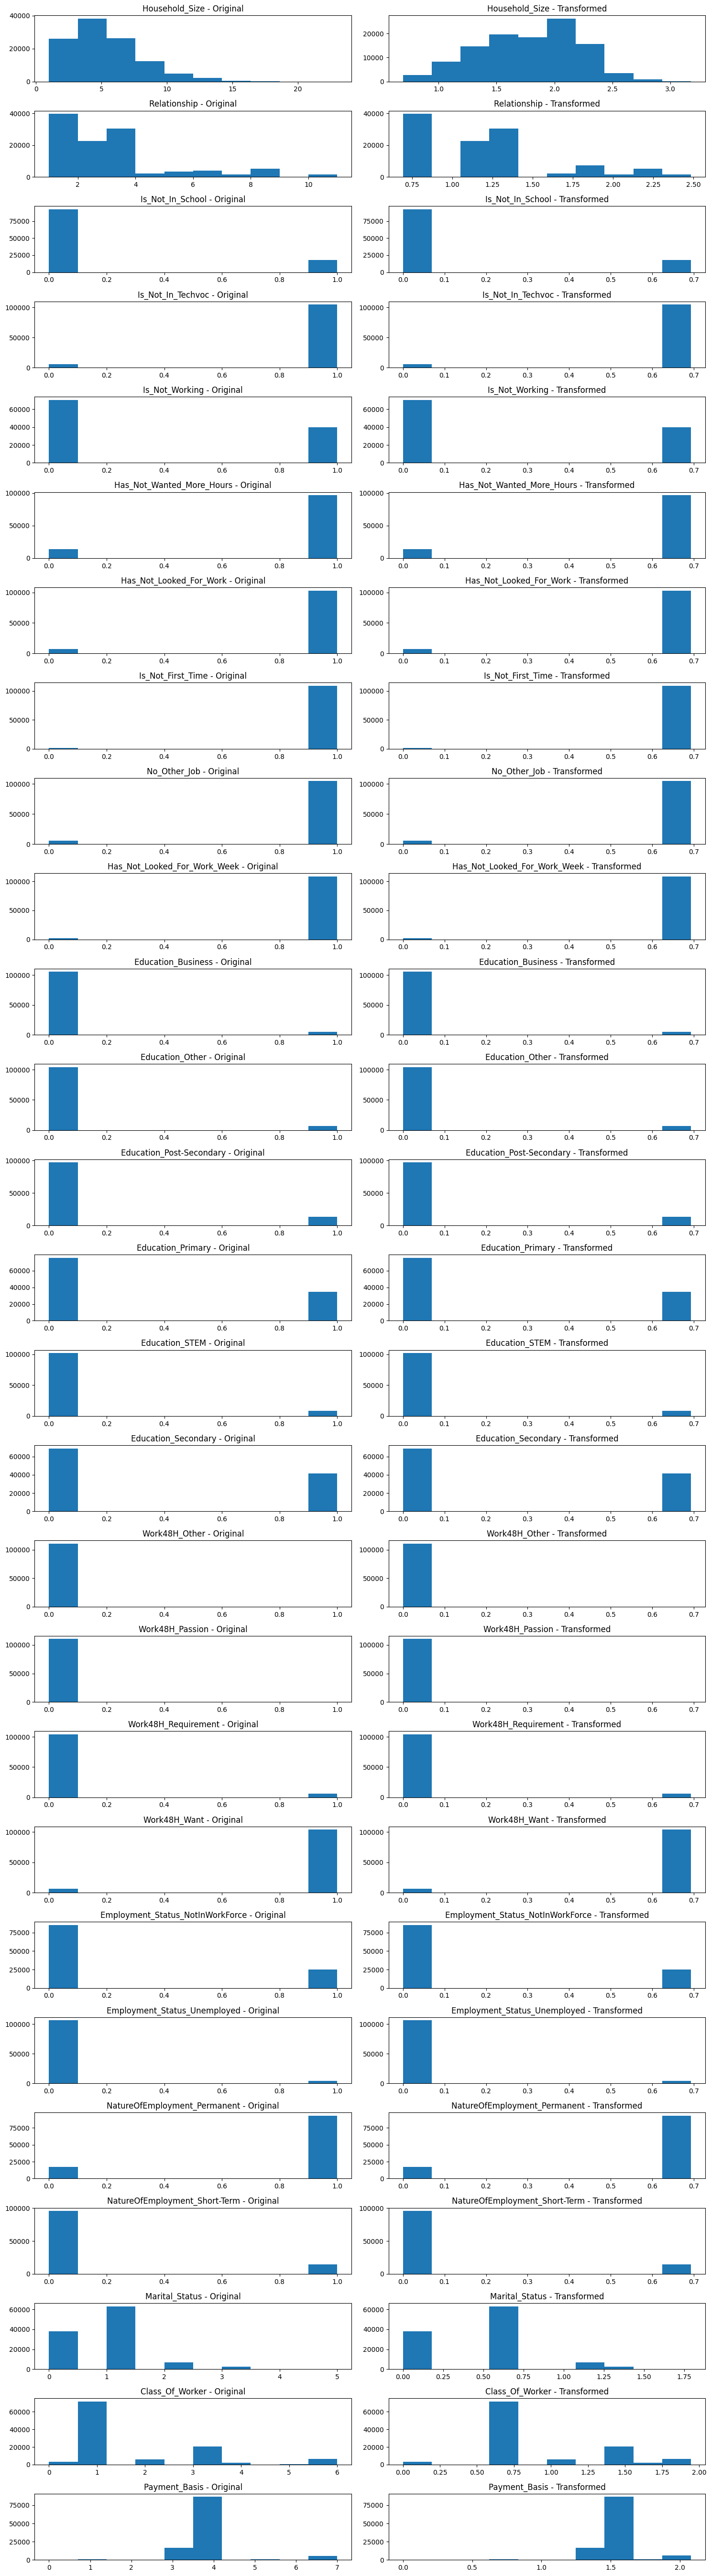

In [44]:
DT.visualize()

This shows the scaled columns after transformation.

In [45]:
transformed_df = DT.scaled_df

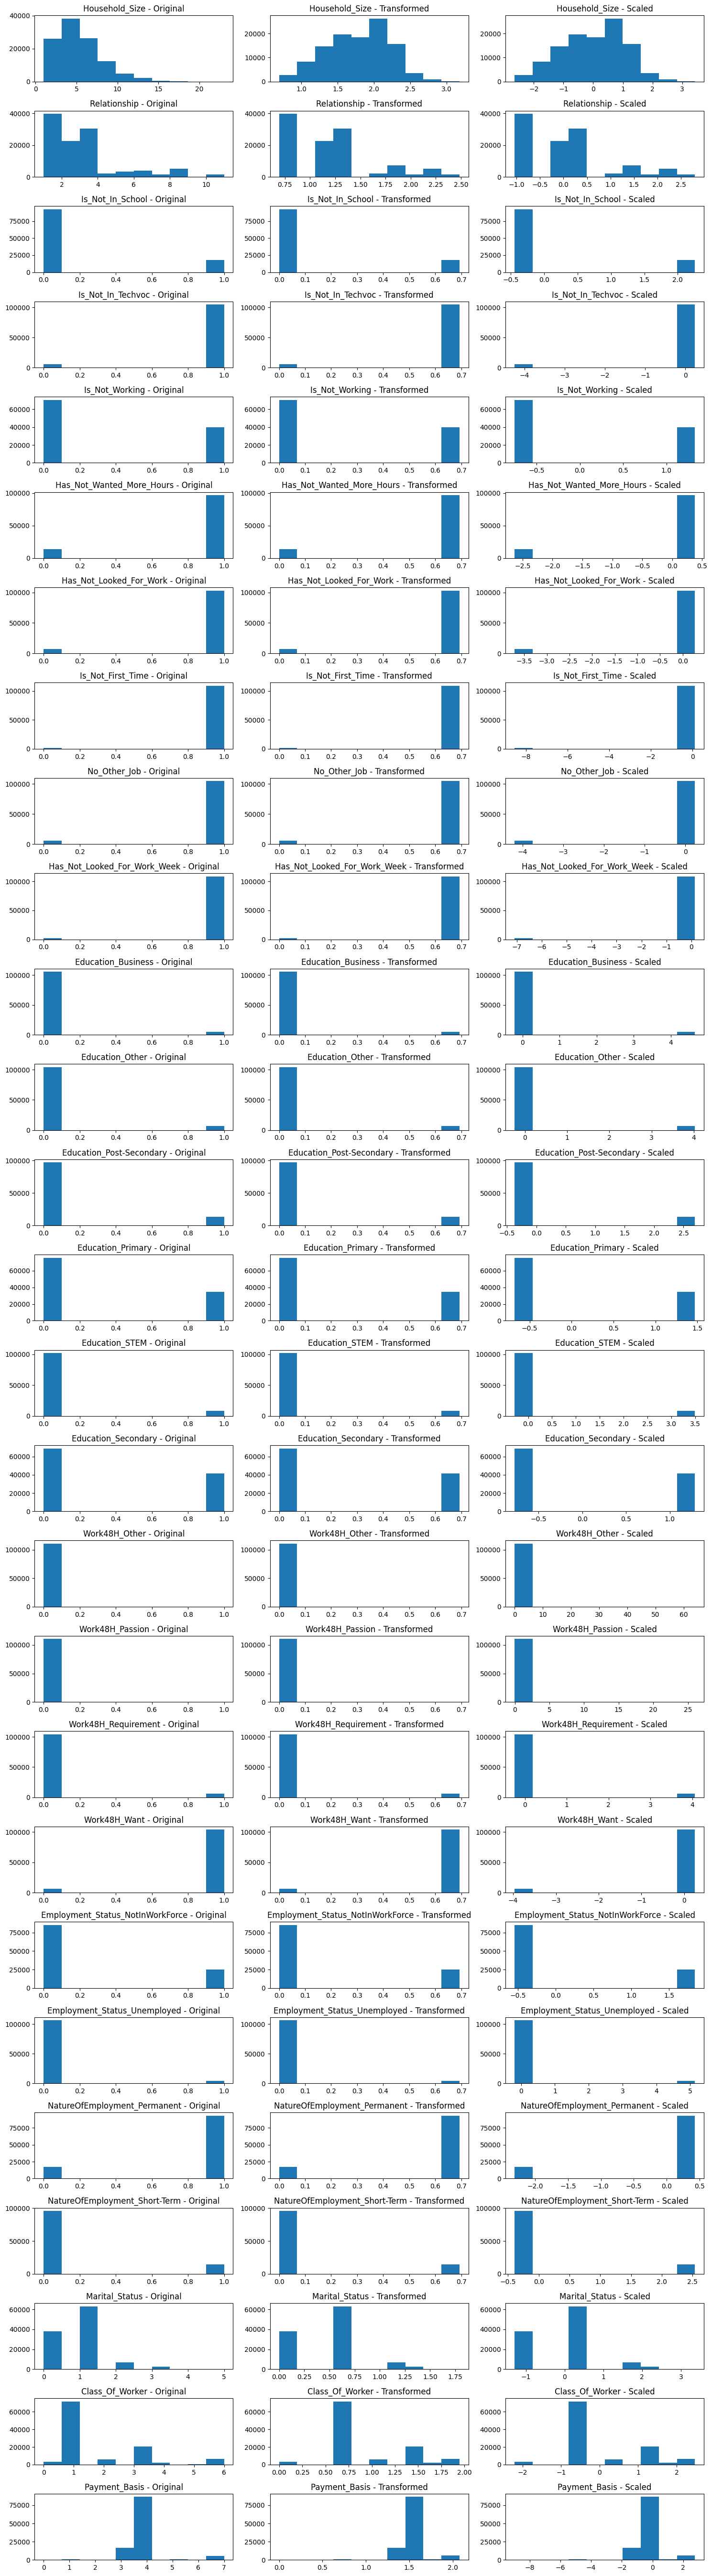

In [46]:
DT.visualize(scaled=True)

## Identify features (X) and labels (y)
Separate the labels from the features for training. This is to ensure the models are properly trained.

In [47]:
target_variable = "Class_Of_Worker"
X = df.drop(columns=[target_variable]).to_numpy()
y = df[target_variable].to_numpy()
X.shape, y.shape

((110536, 31), (110536,))

## Train-Test Split
This section is dedicated to splitting the dataset into training and testing sets. For consistency, the data will be split using a random seed of 42. and a test_size of 0.2.

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Handling Class Imbalance
To handle class imbalance, we can use the Synthetic Minority Over-sampling Technique (SMOTE) to oversample the minority classes. This technique generates synthetic samples to balance the class distribution.

In [49]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Initial Random Forest Model

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from random_forest_model import preprocess_data, train_random_forest, evaluate_model, train_gradient_boosting

In [51]:
target_column = "Class_Of_Worker"
X, y = preprocess_data(df, target_column)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
model = train_random_forest(X_train, y_train)

In [54]:
model = train_random_forest(X_train_resampled, y_train_resampled)

In [55]:
evaluate_model(model, X_test, y_test)

Accuracy: 0.5156956757734756
Classification Report:
              precision    recall  f1-score   support

           0       0.06      0.68      0.12       661
           1       0.72      0.76      0.74     14350
           2       0.00      0.00      0.00      1279
           3       0.00      0.00      0.00      4064
           4       0.00      0.00      0.00       449
           5       0.00      0.00      0.00        38
           6       0.00      0.00      0.00      1267

    accuracy                           0.52     22108
   macro avg       0.11      0.21      0.12     22108
weighted avg       0.47      0.52      0.49     22108

Confusion Matrix:
[[  448   213     0     0     0     0     0]
 [ 3395 10953     2     0     0     0     0]
 [  720   559     0     0     0     0     0]
 [ 1562  2502     0     0     0     0     0]
 [  150   299     0     0     0     0     0]
 [   22    16     0     0     0     0     0]
 [  701   566     0     0     0     0     0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

(0.5156956757734756,
 '              precision    recall  f1-score   support\n\n           0       0.06      0.68      0.12       661\n           1       0.72      0.76      0.74     14350\n           2       0.00      0.00      0.00      1279\n           3       0.00      0.00      0.00      4064\n           4       0.00      0.00      0.00       449\n           5       0.00      0.00      0.00        38\n           6       0.00      0.00      0.00      1267\n\n    accuracy                           0.52     22108\n   macro avg       0.11      0.21      0.12     22108\nweighted avg       0.47      0.52      0.49     22108\n',
 array([[  448,   213,     0,     0,     0,     0,     0],
        [ 3395, 10953,     2,     0,     0,     0,     0],
        [  720,   559,     0,     0,     0,     0,     0],
        [ 1562,  2502,     0,     0,     0,     0,     0],
        [  150,   299,     0,     0,     0,     0,     0],
        [   22,    16,     0,     0,     0,     0,     0],
        [  

### Improving Random Forest Performance

#### Gradient Boosting and Hyperparamter Tuning

In [56]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [57]:
gb_model = GradientBoostingClassifier(random_state=42)

In [58]:
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

In [59]:
random_search = RandomizedSearchCV(
    gb_model, param_distributions=param_grid,
    n_iter=5, cv=2, scoring='accuracy', n_jobs=-1, verbose=2
)
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


KeyboardInterrupt: 

In [60]:
best_model = random_search.best_estimator_

In [61]:
evaluate_model(best_model, X_test, y_test)

AttributeError: 'NoneType' object has no attribute 'tree_'

### K-NN Algorithm

##### Using K-NN as a machine learning model for classification in  with the target variable of **Class_Of_Worker** to identify if K-NN is an accurate model to use with hyperparameters.

In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [63]:
transformed_df

,Household_Size,Relationship,Age,Is_Rural,Is_Female,Is_Not_In_School,Is_Not_In_Techvoc,Is_Not_Working,Has_Not_Wanted_More_Hours,Has_Not_Looked_For_Work,...,Work48H_Want,Employment_Status_NotInWorkForce,Employment_Status_Unemployed,NatureOfEmployment_Permanent,NatureOfEmployment_Short-Term,Hours_Work_Total,Marital_Status,Working_Hours_Per_Week,Class_Of_Worker,Payment_Basis
0,-0.953469,-1.042266,0.656293,0.891545,-0.926906,-0.443090,0.235517,-0.752860,-2.634108,-3.714741,...,0.252034,-0.542873,-0.194546,0.431789,-0.393749,-0.765810,0.510131,0.166142,1.129496,0.110033
1,-0.953469,-0.173319,1.337910,0.891545,1.078859,-0.443090,0.235517,-0.752860,0.379635,0.269198,...,0.252034,-0.542873,-0.194546,-2.315948,2.539690,-2.292877,0.510131,-1.818585,2.477401,0.110033
2,-0.953469,0.443208,-1.047749,0.891545,-0.926906,2.256877,0.235517,-0.752860,-2.634108,-3.714741,...,0.252034,-0.542873,-0.194546,-2.315948,2.539690,-0.638555,-1.290141,0.166142,-0.540037,-1.151876
3,-0.407731,-1.042266,0.599492,0.891545,-0.926906,-0.443090,0.235517,-0.752860,-2.634108,-3.714741,...,0.252034,-0.542873,-0.194546,0.431789,-0.393749,-0.702182,0.510131,-1.818585,1.129496,0.110033
4,-0.407731,-0.173319,0.201882,0.891545,1.078859,-0.443090,0.235517,-0.752860,0.379635,0.269198,...,-3.967720,-0.542873,-0.194546,0.431789,-0.393749,1.779301,0.510131,2.150869,-2.209569,0.110033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110531,0.741749,-1.042266,-0.195728,0.891545,-0.926906,-0.443090,0.235517,-0.752860,-2.634108,-3.714741,...,0.252034,-0.542873,-0.194546,0.431789,-0.393749,-0.256788,0.510131,-1.322403,1.129496,0.110033
110532,0.741749,-0.173319,-0.309331,0.891545,1.078859,-0.443090,0.235517,-0.752860,-2.634108,-3.714741,...,0.252034,-0.542873,-0.194546,0.431789,-0.393749,0.252235,0.510131,-1.818585,1.129496,0.110033
110533,0.038170,-1.042266,-0.479735,0.891545,-0.926906,-0.443090,0.235517,-0.752860,0.379635,0.269198,...,0.252034,-0.542873,-0.194546,0.431789,-0.393749,-0.256788,0.510131,0.166142,1.666965,0.110033
110534,0.038170,-0.173319,-0.479735,0.891545,1.078859,-0.443090,0.235517,1.328269,0.379635,0.269198,...,0.252034,1.842050,-0.194546,0.431789,-0.393749,0.252235,0.510131,0.166142,-0.540037,0.110033


In [94]:
transformed_df.to_csv("transformed_df.csv", index=False)

In [95]:
X = transformed_df.drop('Class_Of_Worker', axis=1)
y = transformed_df['Class_Of_Worker']

Without hyperparameter tuning

In [96]:
y = y.astype(int)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN model (default k=5)
classifier = KNeighborsClassifier()
classifier.fit(X_train_scaled, y_train)  # Train classifier

# Predictions
y_pred = classifier.predict(X_test_scaled)

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

          -2       0.54      0.41      0.47       661
           0       0.92      0.96      0.94     15629
           1       0.77      0.77      0.77      4513
           2       0.58      0.41      0.48      1305

    accuracy                           0.87     22108
   macro avg       0.70      0.64      0.66     22108
weighted avg       0.86      0.87      0.86     22108


Confusion Matrix:
 [[  272   262   102    25]
 [  145 14927   473    84]
 [   51   714  3473   275]
 [   33   269   466   537]]

Accuracy Score: 0.8688709969241903


With hyperparameter tuning

In [103]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Hyperparameter tuning using Optuna for a faster and smarter searching, and automatiacally finding the best parameters.

In [104]:
def objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 5, 50, step=5)  # Optimize k
    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance', metric='euclidean')
    return cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()


In [105]:
study = optuna.create_study(direction='maximize')


[I 2025-03-30 21:42:43,842] A new study created in memory with name: no-name-6e86fa2f-e327-434e-bad4-afe9e807085d


In [106]:
study.optimize(objective, n_trials=10)

# Print best parameters
print("Best hyperparameters:", study.best_params)

[I 2025-03-30 21:43:41,276] Trial 0 finished with value: 0.8576016669516943 and parameters: {'n_neighbors': 45}. Best is trial 0 with value: 0.8576016669516943.
[I 2025-03-30 21:44:32,055] Trial 1 finished with value: 0.8640023676939579 and parameters: {'n_neighbors': 20}. Best is trial 1 with value: 0.8640023676939579.
[I 2025-03-30 21:45:29,021] Trial 2 finished with value: 0.8623399956217994 and parameters: {'n_neighbors': 25}. Best is trial 1 with value: 0.8640023676939579.
[I 2025-03-30 21:46:18,856] Trial 3 finished with value: 0.8652802586994033 and parameters: {'n_neighbors': 15}. Best is trial 3 with value: 0.8652802586994033.
[I 2025-03-30 21:47:09,085] Trial 4 finished with value: 0.8640023676939579 and parameters: {'n_neighbors': 20}. Best is trial 3 with value: 0.8652802586994033.
[I 2025-03-30 21:47:59,435] Trial 5 finished with value: 0.8623399956217994 and parameters: {'n_neighbors': 25}. Best is trial 3 with value: 0.8652802586994033.
[I 2025-03-30 21:48:51,294] Trial 

Best hyperparameters: {'n_neighbors': 10}


Best hyperparameter detected was n_neighbors = 10

In [110]:
best_knn = KNeighborsClassifier(n_neighbors=10)
best_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [111]:
y_pred = best_knn.predict(X_test)

In [112]:
print("\n" + classification_report(y_test, y_pred) + "\n")
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

          -2       0.59      0.40      0.48       661
           0       0.92      0.96      0.94     15629
           1       0.77      0.77      0.77      4513
           2       0.59      0.41      0.48      1305

    accuracy                           0.87     22108
   macro avg       0.72      0.63      0.67     22108
weighted avg       0.86      0.87      0.86     22108


[[  262   264   108    27]
 [  125 14986   440    78]
 [   29   757  3469   258]
 [   25   281   468   531]]


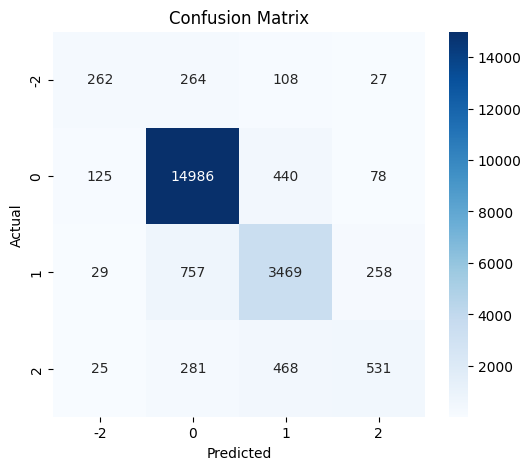

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Artificial Neural Networks
Let us make predictions using an artificial neural network (ANN). We will first do so using default or commonly used parameters. Then, we will perform performance enhancing techniques to improve the model's performance.

## Import Necessary Modules
We will need to import the NeuralNetwork class from neural_network.py as well as other relevant modules


In [ ]:
import torch
import pandas as pd
from neural_network import  train_neural_network, evaluate_model, tune_hyperparameters

## Initialize the model

In [ ]:
"""
Idenfifying the target column and the features, as well as splitting the datainto training
and test sets are no longer necessary as they had already been done earlier in the notebook.

"""

# Get input size and number of classes
input_size = X_train.shape[1]
num_classes = len(set(y_train))

# Define initial model parameters
list_hidden = [64, 32]
activation = 'relu'
learning_rate = 0.01
epochs = 100


## Train the model
Perform an initial training of the model using the default parameters

In [ ]:
initial_model = train_neural_network(X_train, y_train, input_size, list_hidden, num_classes, activation, epochs, learning_rate)

## Evaluate Model on Test Set

In [ ]:
evaluate_model(initial_model, X_test, y_test)

## Initial Results
The model with default hyperparameters produced an accuracy of `74.8960%`. However, based on the classification report, classes 4 and 5 were never predicted at all (recall=0.00), indicating that they are underrepresented in the model's predictions. For now, let us perform hyperparameter tuning.

## Hyperparameter Tuning
Perform hyperparameter tuning using Optuna

In [ ]:
best_params = tune_hyperparameters(X_train, y_train, input_size, num_classes, n_trials=40)
print("Best Hyperparameters:", best_params)

## Results

Performing 40 trials of hyperparameter tuning with Optuna, the following values hyperparameters were found to be the best:
- num-layers: 2
- hidden_list [24, 101]
- learning_rate: 0.0081603746771058
- activation: 'relu'
- epochs: 161

## Retrain the Model
Apply the best hyperparameters to the same model

In [ ]:
# Redefine the hyperparemeters
list_hidden = [24, 101]
activation = 'relu'
learning_rate = 0.0081603746771058
epochs = 161

tuned_model = train_neural_network(X_train, y_train, input_size, list_hidden, num_classes, activation, epochs, learning_rate)

## Evaluate the Retrained Model

In [ ]:
evaluate_model(tuned_model, X_test, y_test)

## Results
The retrained model produced a test accuracy of `82.7619%`, which is higher than the initial accuracy of `74.8960%`. Let us perform a paired t-test to see if the hyperparameter tuning resulted in a significant model improvement.


## Statistical Tests

In [ ]:
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score

# Get predictions from both models
y_pred_initial = initial_model.predict(torch.tensor(X_test, dtype=torch.float32)).numpy()
y_pred_optimized = tuned_model.predict(torch.tensor(X_test, dtype=torch.float32)).numpy()

# Compute accuracy scores
acc_initial = accuracy_score(y_test, y_pred_initial)
acc_optimized = accuracy_score(y_test, y_pred_optimized)

# Perform statistical test (paired t-test)
t_stat, p_value = ttest_ind(y_pred_initial, y_pred_optimized)

print(f"Initial Model Accuracy: {acc_initial:.4f}")
print(f"Optimized Model Accuracy: {acc_optimized:.4f}")
print(f"T-test Statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

if p_value < 0.05:
    print("The improvement in model accuracy is statistically significant.")
else:
    print("No significant improvement in model accuracy.")
